## Try phase association for stations for October 2014
Refernce: https://github.com/yetinam/pyocto

In [ ]:
# !pip3 install numpy
# !pip3 install pyrocko

In [1]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy import signal
from obspy.signal.trigger import classic_sta_lta
import pygmt

from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from pnwstore.mseed import WaveformClient


In [2]:
# Import the velocity model from https://colab.research.google.com/github/yetinam/pyocto/blob/main/examples/02_velocity_models.ipynb#scrollTo=1c52ed9e-d9c1-4fa6-a549-de702bc9d439
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

## Input Data

In [3]:
picks = pd.read_csv("../../data/datasets_OR_010/picks_OR_010.csv",index_col=0)
stations = pd.read_csv("../../data/datasets_OR_010/all_stations_OR_010.csv",index_col=0)

In [4]:
picks

,station,phase,time
0,BABR,P,2016-06-04T00:36:00.415000Z
1,JEDS,P,2016-06-04T00:35:56.715000Z
2,HYS14,P,2016-06-04T00:35:48.000000Z
3,FISH,P,2016-06-04T00:36:13.088393Z
4,HYSB1,P,2016-06-04T00:35:44.675000Z
5,BABR,S,2016-06-04T00:36:21.515000Z
6,JEDS,S,2016-06-04T00:36:15.640000Z
7,HYS14,S,2016-06-04T00:36:03.435000Z
8,FISH,S,2016-06-04T00:36:43.618393Z


In [5]:
stations

,id,longitude,latitude,elevation
0,BABR,-123.789240,44.621320,438.7
1,JEDS,-124.049050,43.751570,159.5
2,HYS14,-125.147900,44.569157,-775.0
3,FISH,-123.559100,45.930600,327.0
4,HYSB1,-125.405258,44.509791,-2908.0


## Create a 1D velocity model
Not needed for now.

In [6]:
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

In [7]:
layers = pd.read_csv("../../data/datasets_all_stations/graeber.csv")
layers

,depth,vp,vp_grad,vs,vs_grad,x,y
0,0.0,6.1,0.00,3.6,0.00,1.0,0.0
1,10.0,6.1,0.03,3.6,0.02,1.0,0.0
2,20.0,6.4,0.01,3.8,0.01,1.0,0.0
3,30.0,6.5,0.06,3.8,0.04,1.0,0.0
4,40.0,7.1,0.00,4.2,0.00,1.0,0.0
5,50.0,7.1,0.02,4.2,0.01,1.0,0.0
6,60.0,7.3,0.06,4.3,0.04,1.0,0.0
7,70.0,7.9,0.02,4.7,0.01,1.0,0.0
8,80.0,8.1,0.04,4.8,0.02,1.0,0.0
9,90.0,8.5,0.00,5.1,0.00,1.0,0.0


In [8]:
model_path = "velocity_model"
pyocto.VelocityModel1D.create_model(layers, 1., 400, 250, model_path)

In [9]:
velocity_model_1d = pyocto.VelocityModel1D(model_path, tolerance=2.0)

## The OctoAssociator class

In [10]:
#  Define the associator parameters
associator = pyocto.OctoAssociator.from_area(
    lat=(39, 50),
    lon=(-128, -123),
    zlim=(0, 50),
    time_before=300,
    velocity_model=velocity_model_1d,
    n_picks=6,
    n_p_picks=3,
    n_s_picks=3,
    n_p_and_s_picks=3,
)

In [11]:
associator.transform_stations(stations)
stations

,id,longitude,latitude,elevation,x,y,z
0,BABR,-123.789240,44.621320,438.7,135.773848,14.905477,-0.4387
1,JEDS,-124.049050,43.751570,159.5,116.860227,-82.138217,-0.1595
2,HYS14,-125.147900,44.569157,-775.0,27.969240,7.745222,0.7750
3,FISH,-123.559100,45.930600,327.0,150.535481,160.823442,-0.3270
4,HYSB1,-125.405258,44.509791,-2908.0,7.533529,1.092363,2.9080


## Convert the timestamps to floats

In [12]:
# Convert the times to timestamps
picks["time"] = picks["time"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

,station,phase,time
0,BABR,P,1.465001e+09
1,JEDS,P,1.465001e+09
2,HYS14,P,1.465001e+09
3,FISH,P,1.465001e+09
4,HYSB1,P,1.465001e+09
5,BABR,S,1.465001e+09
6,JEDS,S,1.465001e+09
7,HYS14,S,1.465001e+09
8,FISH,S,1.465001e+09


In [13]:
# picks['time'] = picks['time'].apply(lambda x: (datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ')).timestamp())
# picks

## Apply  the associator

In [14]:
# Association 
events, assignments = associator.associate(picks, stations)

In [15]:
# Print the associated events
events

,idx,time,x,y,z,picks
0,0,1.465001e+09,-46.107948,-52.653525,49.609375,8


In [16]:
# Count how many picks each event has
Counter(events['picks'])

Counter({8: 1})

In [17]:
# Convert the event times and the x, y, and z coordinate to latitudes, longitudes, and depths, respectively
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)

In [18]:
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375


In [19]:
#  Save events that have at least 6 picks
events = events.loc[(events['picks'] >= 6)]
events.to_csv('../../data/datasets_OR_010/events_OR_010.csv')


In [20]:
# events.to_csv('~/notebooks/src/association_events.csv')

In [20]:
# Print the assignments
assignments

,event_idx,pick_idx,residual,station,phase,time
0,0,0,-0.567953,BABR,P,1.465001e+09
1,0,5,-0.449457,BABR,S,1.465001e+09
2,0,3,-0.684313,FISH,P,1.465001e+09
3,0,8,0.173698,FISH,S,1.465001e+09
4,0,2,0.831790,HYS14,P,1.465001e+09
5,0,4,0.459011,HYSB1,P,1.465001e+09
6,0,1,-0.243745,JEDS,P,1.465001e+09
7,0,6,0.480971,JEDS,S,1.465001e+09


In [21]:
# Assign the event information to each pick by using pd.merge
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))
all_pick_assignments

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375,0,0,-0.567953,BABR,P,1.465001e+09
1,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375,0,5,-0.449457,BABR,S,1.465001e+09
2,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375,0,3,-0.684313,FISH,P,1.465001e+09
3,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375,0,8,0.173698,FISH,S,1.465001e+09
4,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375,0,2,0.831790,HYS14,P,1.465001e+09
5,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375,0,4,0.459011,HYSB1,P,1.465001e+09
6,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375,0,1,-0.243745,JEDS,P,1.465001e+09
7,0,2016-06-04 00:35:30.706779+00:00,-46.107948,-52.653525,49.609375,8,44.024698,-126.075106,49.609375,0,6,0.480971,JEDS,S,1.465001e+09


In [23]:
# Save the assignments to a CSV file
all_pick_assignments.to_csv("../../data/datasets_OR_010/all_pick_assignments_OR_010.csv")

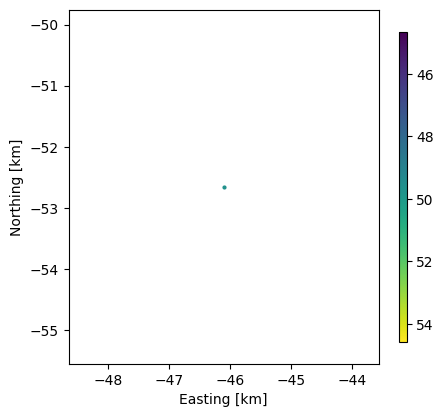

In [24]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],s=4,cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()